# Le problème de la couverture exacte

## Objet du problème

$F$ étant un ensemble de parties non vides d'un ensemble fini $E$,
il s'agit de trouver une partie $C$ de 
$F$ qui constitue une partition de $E$ (les éléments de $C$ sont 2 à 2 disjoints et leur réunion est $E$).
On dit que $C$ est une *couverture exacte*. 

Par exemple, avec $E=\{0,1,2,3,4,5,6\}$, une couverture exacte de
$F=\{\{2,4,5\},\{0,3,6\},\{1,2,5\},\{0,3\},\{1,6\},\{3,4,6\}\}$ est
$C=\{\{2,4,5\},\{0,3\},\{1,6\}\}$.

## L'algorithme X

couverture-exacte$(E,F)$ :  
&nbsp;&nbsp;&nbsp;&nbsp;**si** $E=\emptyset$ **alors**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**renvoyer** $\emptyset$  
&nbsp;&nbsp;&nbsp;&nbsp;**sinon**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**choisir** $x\in E$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**pour tout** $P$ tel que $x\in P\in F$  **faire**    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$E'\leftarrow E\setminus P$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$F'\leftarrow\{Q\in F\,,\,P\cap Q=\emptyset\}$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**si** couverture-exacte$(E',F')$ renvoie $C$ **alors**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**renvoyer** $C\cup\{P\}$

Cet algorithme termine car le cardinal de $E'$ dans
les appels récursifs est strictement inférieur à celui de $E$.  
La structure même de l'algorithme fournit une preuve de sa validité.

## Implémentation

### Méthode élémentaire
On peut implémenter l'algorithme en Python, voir par exemplee [ici](https://www.cs.mcgill.ca/~aassaf9/python/algorithm_x.html). 

### Méthode de Knuth
[Donald Knuth](https://www-cs-faculty.stanford.edu/~knuth/) a mis au point une méthode efficace : les [liens dansants](https://arxiv.org/pdf/cs/0011047.pdf). Mais cette méthode, qui est basée sur une utilisation astucieuse de pointeurs,  perd son efficacité si on l'implémente en pur Python et il faut utiliser le langage C. A ma connaissance, il n'existe pas de module Python implémentant les liens dansants en C. Par contre, un tel module existe en [Sage](https://www.sagemath.org/). Le code suivant est environ 10 fois plus rapide que toute implémentation pur Python.

In [1]:
class AlgorithmeX:

    def __init__(self, F, obl = [], fac = []):

        """F est un dictionnaire d'objets hashables :
        {<choix> : [<contrainte>,...],...}
        obl est la liste des choix obligatoires.
        fac est la liste des contraintes facultatives.
        """

        self.dictFac = {'_facultatif' + str(i) : [k] for i,k in enumerate(fac)}
        self.F = {**F, **self.dictFac}
        E = set() 
        for l in self.F: E |= set(self.F[l])  
        self.E = list(E)    
        self.cardF = len(self.F)
        self.obl = obl

    def solve(self):
        """Renvoie un iterateur des solutions 
        """
        from sage.combinat.matrices.dancing_links import dlx_solver
        dictE = {k : int(i) for i, k in enumerate(self.E)}
        keysF = list(self.F.keys())
        dictF = {k : int(i) for i, k in enumerate(self.F)}
        entiersF = [list(map((lambda o: dictE[o]),self.F[keysF[i]])) for i in range(self.cardF)]
        def solutions():
            for s in dlx_solver(entiersF).restrict(map((lambda o: dictF[o]),self.obl)).solutions_iterator():
                yield list(set(map((lambda i: keysF[i]),s)) - set(self.dictFac.keys()))
        return solutions()

    def printSolution(self,sol):
        for l in sol: print(self.F[l])            

### Test 1

In [2]:
F = {'1': [1,2],'2': [3,4,5],'3': [0,1],'4': [2,3,4,5],'5': [0],'6': [1,2,3,4,5,6]}
aX = AlgorithmeX(F,obl=['5'],fac=[6])
for sol in aX.solve(): print(sol)       

['2', '5', '1']
['6', '5']


### Test 2

In [3]:
F = {'A' : ['1', 4, '7'],
     'B' : ['1', 4],
     'C' : [4, '5', '7'],
     'D' : [ '5','3', '6'],
     'E' : [ (3,4), '3', '6', '7'],
     'F' : [ (3,4), '7']}

aX = AlgorithmeX(F)
#for sol in aX.solve(): print(sol)    
for sol in aX.solve(): aX.printSolution(sol)    

['5', '3', '6']
['1', 4]
[(3, 4), '7']


## Application au Sudoku

In [4]:
class SUDOKU:

    def __init__(self,p = 3,q = 3,t = None):
    
        """Un probleme de sudoku est represente par :
        1. un ensemble de symboles ;
        2. la taille (p,q) qui definit une
           matrice carree (n,n) ou n = p * q,
           les n lignes sont partagees en q groupes de p lignes,
           les n colonnes sont partagees en p groupes de q colonnes,
           le carre est donc partage en n blocs rectangulaires p x q.
        3. une affectation de symboles a certaines cases
           de la matrice.
        """

        self.n = p * q
        if t:
            self.t = list(map(list,t.split()))         
        else:
            self.t = [['.' for j in range(self.n)] for i in range(self.n)]
        self.symboles = '123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'[:self.n]
        self.lignes = {(s,i,j) : [(i,j),('L',s,i),('C',s,j),('B',s,i//p,j//q)]
                       for s in self.symboles
                       for i in range(self.n) for j in range(self.n)}
        self.obl = [(s,i,j) for s in self.symboles for i in range(self.n) for j in range(self.n)
                            if s == self.t[i][j] != '.']

    def solve(self):
        
        for sol in AlgorithmeX(self.lignes,obl = self.obl).solve():
            for s,i,j in sol:
                self.t[i][j] = s
            yield '\n'.join(' '.join(ligne) for ligne in self.t)
  

### Test

In [5]:
t = """
    ..8.5....      
    .4....3..
    ......1..
    .7.3.....      
    ....2..8.
    1......5.
    ..57...4.
    ...1..6..
    2........
"""        
    
s = SUDOKU(t = t).solve()
print(next(s))

3 2 8 9 5 1 4 7 6
7 4 1 2 8 6 3 9 5
9 5 6 4 7 3 1 2 8
5 7 9 3 1 8 2 6 4
4 6 3 5 2 7 9 8 1
1 8 2 6 9 4 7 5 3
6 1 5 7 3 2 8 4 9
8 9 7 1 4 5 6 3 2
2 3 4 8 6 9 5 1 7


## Application au problème des 8 reines

In [6]:
class QUEENS:

    def __init__(self,n = 8):
    
        self.n = n
        self.lignes = {(i,j) : [('L',i), ('C',j), ('D1', i + j), ('D2', i - j)]
                       for i in range(n) for j in range(n)}
        self.facultatifs = [('D1', k) for k in range(0, 2 * n - 1)] + [('D2', k) 
                                                      for k in range(- n + 1, n)] 
        
    def solve(self):

        for sol in AlgorithmeX(self.lignes,fac = self.facultatifs).solve():
            s = [j for i,j in sorted(sol,key = lambda c: c[0])]
            yield '\n'.join('. ' * s[i] + 'X ' + '. ' * (self.n - s[i] - 1) 
                                                  for i in range(self.n))
      

### Test

In [7]:
q = QUEENS()
s = q.solve()
print(next(s))

. . . . . . . X 
. X . . . . . . 
. . . X . . . . 
X . . . . . . . 
. . . . . . X . 
. . . . X . . . 
. . X . . . . . 
. . . . . X . . 


## Application aux puzzles

In [8]:
class PIECE:

    def __init__(self,nom,piece,couleur = None):
        self.nom = nom
        self.piece = piece
        self.couleur = couleur
        self.largeur = len(self.piece[0])
        self.hauteur = len(self.piece)

    def __hash__(self):
        return hash(self.piece)

    def __eq__(self,q):
        return self.piece == q.piece

    def __str__(self):
        return str((self.nom,self.piece))

    def transposee(self):
        q = self.piece
        return PIECE(self.nom, 
                     tuple(tuple(q[j][i] for j in range(self.hauteur)) 
                                  for i in range(self.largeur)))

    def rotation(self):
        q = self.piece
        return PIECE(self.nom, 
                     tuple(tuple(q[self.hauteur - j - 1][i] for j in range(self.hauteur)) 
                                  for i in range(self.largeur)))
                    
    def isometriques(self):
        p1 = self.rotation()
        p2 = p1.rotation()
        p3 = p2.rotation()
        q0 = self.transposee()
        q1 = q0.rotation()
        q2 = q1.rotation()
        q3 = q2.rotation()
        return list({self,p1,p2,p3,q0,q1,q2,q3})
 
    def polygoneOfCouples(e):
        """e est un ensemble de couples d'entiers (i,j)
        representant une piece (un polyomino).
        Renvoie une liste de deux tuples pour le dessin de la piece.
        """
        segments = set()
        for i,j in e:
            if (i + 1, j) not in e: segments.add(((i+1,j),(i+1,j+1)))
            if (i, j + 1) not in e: segments.add(((i+1,j+1),(i,j+1))) 
            if (i - 1, j) not in e: segments.add(((i,j+1),(i,j)))
            if (i, j - 1) not in e: segments.add(((i,j),(i+1,j))) 
        (i,j),(k,l) = segments.pop()
        l = [(i,j),(k,l)]
        while True:
            try:
                l.append({s[1] for s in segments if s[0] == l[-1]}.pop())
            except KeyError: break        
        return list(zip(*l))

    def polygone(self, transformation = None):
        """Renvoie une liste de deux tuples pour le dessin de self.
        Si transformation != None,  c'est une liste de listes representant 
        une matrices (2,2) qui est appliquee au polygone.
        """

        e = {(i,j) for i in range(self.largeur)
                   for j in range(self.hauteur)
                   if self.piece[i][j]}
        p = PIECE.polygoneOfCouples(e)
        if transformation:
            [[a,b],[c,d]] = transformation
            f = lambda z: (a * z[0] + b * z[1], c * z[0] + d * z[1])
            return list(zip(*map(f,zip(*p))))
        else:
            return p

class PUZZLE:

    def __init__(self,pieces,
                      min_i,max_i,min_j,max_j,
                      conditions = None,
                      strict = True):
        """pieces : liste de PIECE
        min_i,max_i,min_j,max_j : definition du plateau
        conditions : couple d'entiers -> booleen restreignant le plateau
    
        1er cas  : strict = True
            Pour chacun des noms des pieces, il faut placer 
            une et une seule piece portant ce nom.
            Les elements de E sont les noms des pieces
            et les cases (couples d'entiers) du plateau.
            Chaque element de F contient un et un seul nom
            et les cases du plateau utilisees par une piece de ce nom..
        
        2eme cas : strict = False
            Pour chaque piece de pieces, on dispose,
            pour resoudre le puzzle, d'autant d'exemplaires
            que l'on veut de la piece.
            Les elements de E sont les cases du plateau.
        """
        self.min_i = min_i
        self.max_i = max_i
        self.min_j = min_j
        self.max_j = max_j
        self.strict = strict
        self.pieces = pieces
        if not conditions:
            conditions = lambda i,j: True
        lignes = dict()
        nbLignes = 0
        for p in pieces:
            for u in range(min_i, max_i - p.largeur + 2):
                for v in range(min_j, max_j - p.hauteur + 2):
                   ligne = [p.nom] if self.strict else []
                   match = True
                   for i in range(p.largeur):
                       if match:
                           ic = i + u 
                           for j in range(p.hauteur):
                               jc = j + v
                               if p.piece[j][i] == 1:
                                   if conditions(ic,jc):
                                       ligne.append((ic,jc))
                                   else:
                                       match = False
                                       break
                       else:
                           break  
                   if match:
                       lignes[nbLignes] = ligne
                       nbLignes += 1
        self.lignes = lignes
        
    def solve(self):
        
        F = self.lignes
        return AlgorithmeX(F).solve()

    def printSolution(self,sol):     
        for l in sol: print(self.lignes[l])

    def plotSolution(self,sol):
        """Pour afficher plusieurs solutions :
        executer un script ou utiliser jupyter
        """
        import matplotlib
        import matplotlib.pyplot as plt
        if not self.strict: from random import random
        matplotlib.rcParams['toolbar'] = 'None'
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111)
        ax.axis('off')
        ax.axis('equal')
        ax.axis([self.min_i - 1, self.max_i + 1,
                 self.min_j - 1, self.max_j + 1])
        for l in sol:
            e = set()
            for c in self.lignes[l]:
                if type(c) == tuple:
                    e.add(c)
                else:
                    couleur = eval(c).couleur 
            if not self.strict: couleur = (random(),random(),random())                               
            ax.fill(*PIECE.polygoneOfCouples(e),
                      facecolor = couleur,
                      edgecolor='black', 
                      linewidth=1)
        #fig.show() # commenter si notebook


#------------------------------- PENTOMINOS ----------------------------

F = PIECE( 'F',((0,1,1),
                (1,1,0),
                (0,1,0)), couleur = 'yellow')
I = PIECE('I',((1,),
               (1,),
               (1,),
               (1,),
               (1,)), couleur = 'plum')
L = PIECE('L',((1,0),
               (1,0),
               (1,0),
               (1,1)), couleur = 'orangered')
N = PIECE('N',((0,1),
               (0,1),
               (1,1),
               (1,0)), couleur = 'dimgray')
P = PIECE('P',((1,1),
               (1,1),
               (1,0)), couleur = 'royalblue')
T = PIECE('T',((1,1,1),
               (0,1,0),
               (0,1,0)), couleur = 'green')
U = PIECE('U',((1,0,1),
               (1,1,1)), couleur = 'yellow')
V = PIECE('V',((0,0,1),
               (0,0,1),
               (1,1,1)), couleur = 'darkblue')
W = PIECE('W',((0,0,1),
               (0,1,1),
               (1,1,0)), couleur = 'purple')
X = PIECE('X',((0,1,0),
               (1,1,1),
               (0,1,0)), couleur = 'red')
Y = PIECE('Y',((0,1),
               (1,1),
               (0,1),
               (0,1)), couleur = 'darkred')
Z = PIECE('Z',((1,1,0),
               (0,1,0),
               (0,1,1)), couleur = 'grey')
        

### Test

['L', (1, 2), (1, 3), (1, 4), (1, 5), (2, 5)]
['T', (1, 1), (2, 1), (2, 2), (2, 3), (3, 1)]
['Y', (2, 4), (3, 2), (3, 3), (3, 4), (3, 5)]


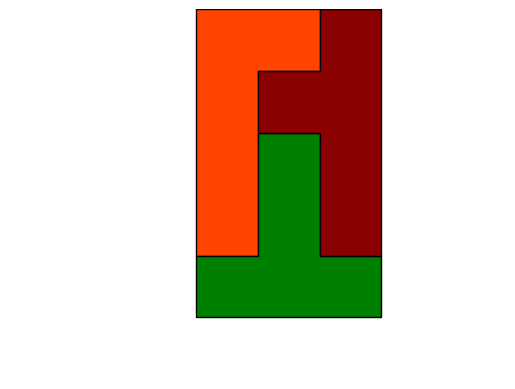

In [9]:
puzzle = PUZZLE([L] + T.isometriques() + Y.isometriques(),1,3,1,5)
for sol in puzzle.solve():
    puzzle.plotSolution(sol)
    puzzle.printSolution(sol)

### Exemple 1

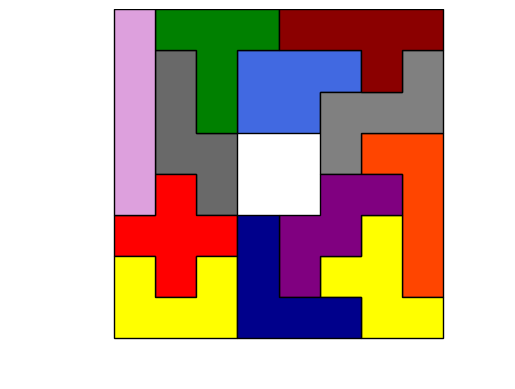

In [10]:
# 65 solutions

pentominos = [F]
for p in [I,L,N,P,T,U,V,W,X,Y,Z]: pentominos += p.isometriques()

puzzle = PUZZLE(pentominos,1,8,1,8,
                conditions = (lambda i,j: not (4 <= i <= 5 and 4 <= j <= 5)))
    
s = puzzle.solve()
        
sol = next(s)
puzzle.plotSolution(sol)
#puzzle.printSolution(sol)


### Exemple 2

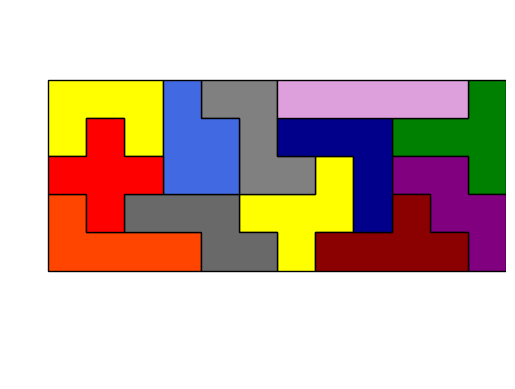

In [11]:
# 1010 solutions

#from puzzle import * # commenter si notebook

pentominos = [F,F.rotation()]
for p in [I,L,N,P,T,U,V,W,X,Y,Z]: pentominos += p.isometriques()

puzzle = PUZZLE(pentominos,1,12,1,5)
    
s = puzzle.solve()
        
sol = next(s)
puzzle.plotSolution(sol)
#puzzle.printSolution(sol)


### Exemple 3

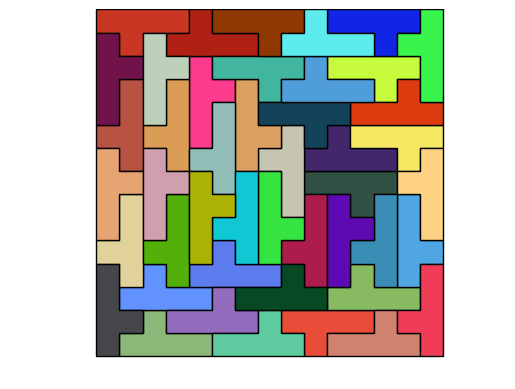

In [12]:
# 8 x 212 = 1696 solutions

puzzle = PUZZLE(Y.isometriques(),1,15,1,15,strict = False)    
       
s = puzzle.solve()
            
sol = next(s)
puzzle.plotSolution(sol)
#puzzle.printSolution(sol)
